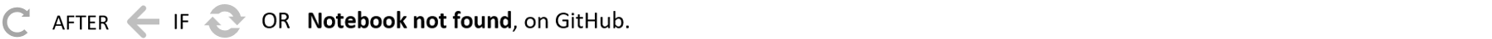

[Return to README](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/README.md#explore-the-project)

# Wikipedia Notable Life Expectancy
## Notebook  13: Modeling for Regression -- Prediction Emphasis
### Contents

This notebook covers:
- First Modeling Iteration using engineered combined `known_for` feature
    - Defining independent and dependent variables for `train` and `validation` sets
    - Model building with various ensemble regressors optimizing $R^2$
    - Hyperparameter tuning of best-performing models
    - Model performance comparison
- Second Modeling Iteration using original `known for` category columns and `num_categories`
    - Defining independent and dependent variables for `train` and `validation` sets
    - Model building with various ensemble regressors optimizing $R^2$
    - Hyperparameter tuning of best-performing models
    - Model performance comparison
- Performance comparison of contender models
- Champion model
    - Performance on `test` Set
    - Feature importances
- Pipelines to productionize champion model
- Sample of pipeline predictions
- Saving custom imputer and productionized model to pickle files
- Conclusion

### Instructions
Options for Running this Notebook:  
***NOTE: This is a long-running notebook.
1. Clone the repository:   
    - Delete the following files that are generated by this notebook:
        - [production_model.pkl](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/production_model.pkl)
        - [X_test.csv](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/X_test.csv)
    - Navigate to the cloned repository in Jupyter and open the notebook to run it.
    - Refer to [Application and Package Versions](https://github.com/teresahanak/wikipedia-life-expectancy#application-and-package-versions).
2. Save the notebook and files below to the same working directory:<sup>1</sup>
    - Download the notebook:
        - Click on <kbd>Raw</kbd> above.
        - Save <kbd>Ctrl</kbd> + <kbd>S</kbd>
    - Follow the link to the csv files and click <kbd>Download</kbd>, then move files to the same directory as the notebook:
        - [wp_life_expect_train_preproc.csv](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_train_preproc.csv)<sup>2</sup>
        - [wp_life_expect_test_preproc.csv](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_test_preproc.csv)<sup>3</sup>
    - In Jupyter, navigate to the directory in which the notebook and files are saved, to open and run the notebook.  
    - Refer to [Application and Package Versions](https://github.com/teresahanak/wikipedia-life-expectancy#application-and-package-versions).

    

### Data Dictionary for Loaded Version of `Train` Set
- **num_references**:  Number of references for individual's page
- **age**: Age of individual at death in years
- **sciences**: (0 for no or 1 for yes) individual known for sciences (math, physics, chemistry, engineering, mechanics, etc.)
- **social**: (0 for no or 1 for yes) individual known for social action (philanthropy, fund-raising for social cause, founder of charity, etc.)
- **spiritual**: (0 for no or 1 for yes) individual known for spiritual association (religious association, traditional healing, self-help/motivational instructor, etc.)
- **academia_humanities**: (0 for no or 1 for yes) individual known for education activity (educator, education administration, lecturer, etc.; excludes sports-related instruction/coaching, but includes art/performing arts instruction; includes museum-related activities; classics, archeology, linguistics, anthropology, etc.)
- **business_farming**: (0 for no or 1 for yes) individual known for business or farming (includes marketing, millionaire/billionaire, manufacturing, oil/energy)
- **arts**: (0 for no or 1 for yes) individual known for arts-related activity (fine and performing arts, journalism, writing, arts administration, art patronage, collecting, etc.; gallery owners/founders are included; museum-related is excluded; stunt performers included)
- **sports**: (0 for no or 1 for yes) individual known for sports-related activity (traditional sports participation/instruction/coaching/ownership/fandom/commentator and anything competition-based, including non-physical games, such as chess; sportswriter, etc. would have dual category of arts)
- **law_enf_military_operator**: (0 for no or 1 for yes) individual known for law enforcement, military/paramilitary association/activity, or specialized equipment operation (pilot, ship captain (non-sport), radio operator, etc.); category aims to reflect individual's proximity to activity and/or weapons/equipment or decision-making that could impact life span, independent of legality of activity
- **politics_govt_law**: (0 for no or 1 for yes) individual known for political activity (official or activism), participation in legal system (lawyer, judge, etc.), nobility or inherited status; directly or by marriage; union activity is included
- **crime**: (0 for no or 1 for yes) individual known for criminal activity; category aims for "innocent until proven guilty"; includes convicted criminals (can be for a different crime); includes individuals labeled "terrorist", but generally excludes individuals awaiting trial
- **num_categories**: Total number of known for categories for individual
- **age_sqrd**: Squared transformation of age ($target^2$)
- **recip_num_references**: Multiplicative inverse transformation of num_references ($1/x$)
- **years**: Translation of year ($year - 1994$)
- **years_sqrd**:  Squared transformation of years ($x^2$)
- **region**: Ultimate location of residency as geographical region
- **prior_region**: Prior location of residency (if applicable) as geographical region
- **known_for**: known for category (equal to original category column name if sole category, or "two" if 2 categories, or "three_to_five" if 3 to 5 categories)

### Importing Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
# import sqlite3 as sql

# To save/open python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np

# To help with categorical typecasting
from pandas.api.types import CategoricalDtype

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
# from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

# To help with model building
from sklearn.tree import DecisionTreeRegressor

# from sklearn.linear_model import LinearRegression

from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    BaggingRegressor,
)
from xgboost import XGBRegressor

# To randomly split data, for cross validation, and to check model performance
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
)

# To be used for tuning the model
from sklearn.model_selection import RandomizedSearchCV

# To be used for hyperparameter tuning searches
from scipy.stats import loguniform
from scipy.stats import uniform
from scipy.stats import expon

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 211)

# To set some dataframe visualization attributes
pd.set_option("max_colwidth", 150)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# To set some plot visualization attributes
sns.set_theme()
sns.set(font_scale=1.4)
sns.set_palette(
    (
        "midnightblue",
        "goldenrod",
        "maroon",
        "darkolivegreen",
        "cadetblue",
        "tab:purple",
        "yellowgreen",
    )
)

# To play auditory cue when cell has executed, has warning, or has error and set chime theme
import chime

chime.theme("zelda")

<IPython.core.display.Javascript object>

## Data Overview

### [Reading](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_train_preproc.csv), Sampling, and Checking Data Shape

In [2]:
# Reading the dataset
data = pd.read_csv("wp_life_expect_train_preproc.csv")

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 77624 rows and 20 columns.


,num_references,age,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,num_categories,age_sqrd,recip_num_references,years,years_sqrd,region,prior_region,known_for
0,4,73.0,0,0,1,0,0,0,0,0,0,0,1,5329.0,0.250000,8,64,Europe,No Prior Region,spiritual
1,3,90.0,1,0,0,1,0,0,0,0,0,0,2,8100.0,0.333333,13,169,North America,No Prior Region,two


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,num_references,age,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,num_categories,age_sqrd,recip_num_references,years,years_sqrd,region,prior_region,known_for
77622,7,74.0,0,0,0,0,0,1,0,0,0,0,1,5476.0,0.142857,0,0,North America,No Prior Region,arts
77623,5,92.0,0,0,0,0,0,0,1,0,0,0,1,8464.0,0.200000,8,64,Europe,No Prior Region,sports


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,num_references,age,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,num_categories,age_sqrd,recip_num_references,years,years_sqrd,region,prior_region,known_for
43562,15,74.0,0,0,0,0,0,0,0,0,1,0,1,5476.0,0.066667,17,289,North America,No Prior Region,politics_govt_law
34509,22,86.0,0,0,0,0,0,1,0,0,1,0,2,7396.0,0.045455,23,529,Europe,No Prior Region,two
18709,5,78.0,0,0,0,0,0,0,0,0,1,0,1,6084.0,0.200000,17,289,Mid-Cent America/Caribbean,Mid-Cent America/Caribbean,politics_govt_law
16897,15,83.0,0,0,0,0,1,0,0,0,0,0,1,6889.0,0.066667,24,576,North America,No Prior Region,business_farming
12199,4,93.0,0,0,0,1,0,0,0,0,0,0,1,8649.0,0.250000,24,576,Europe,No Prior Region,academia_humanities


<IPython.core.display.Javascript object>

### Checking Data Types and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77624 entries, 0 to 77623
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_references             77624 non-null  int64  
 1   age                        77624 non-null  float64
 2   sciences                   77624 non-null  int64  
 3   social                     77624 non-null  int64  
 4   spiritual                  77624 non-null  int64  
 5   academia_humanities        77624 non-null  int64  
 6   business_farming           77624 non-null  int64  
 7   arts                       77624 non-null  int64  
 8   sports                     77624 non-null  int64  
 9   law_enf_military_operator  77624 non-null  int64  
 10  politics_govt_law          77624 non-null  int64  
 11  crime                      77624 non-null  int64  
 12  num_categories             77624 non-null  int64  
 13  age_sqrd                   77624 non-null  flo

<IPython.core.display.Javascript object>

#### Observations:
- With our `Train` set loaded, we are ready for modeling.
- We have three variables that need typcasting from object to category, then one hot encoding just prior to modeling.

#### Typecasting `region`, `prior_region`, and `known_for` as Categorical

In [6]:
# Typcasting prior_region and region as categorical
df[["prior_region", "region", "known_for"]] = df[
    ["prior_region", "region", "known_for"]
].astype("category")

# Re-check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77624 entries, 0 to 77623
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   num_references             77624 non-null  int64   
 1   age                        77624 non-null  float64 
 2   sciences                   77624 non-null  int64   
 3   social                     77624 non-null  int64   
 4   spiritual                  77624 non-null  int64   
 5   academia_humanities        77624 non-null  int64   
 6   business_farming           77624 non-null  int64   
 7   arts                       77624 non-null  int64   
 8   sports                     77624 non-null  int64   
 9   law_enf_military_operator  77624 non-null  int64   
 10  politics_govt_law          77624 non-null  int64   
 11  crime                      77624 non-null  int64   
 12  num_categories             77624 non-null  int64   
 13  age_sqrd                   7762

<IPython.core.display.Javascript object>

## Data Preparation for Modeling
In contrast to building the [linear regression model](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_olsmodel_thanak_2022_10_9.ipynb), we will be tuning these models.  So, we will split the `Train` set into `train` and `validation` sets and utilize the `test` set only to check out-of-sample performance of the champion model.  We will load and treat the `test` set at that point.

### Defining Independent and Dependent Variables for`train` and `validation` Sets

In [7]:
# Creating list of predictor columns
predictor_cols = [
    "num_references",
    "years",
    "region",
    "prior_region",
    "known_for",
]

# Defining target column
target = "age"

# Defining independent and dependent variables
X = df[predictor_cols]
y = df[target]

# One hot encoding of categorical predictors and typecasting all predictors as float
X = pd.get_dummies(X, drop_first=True).astype("float64")

# Splitting into 70:30 train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Checking shape of train and validation sets
print(
    f"There are {X_train.shape[0]} rows and {X_train.shape[1]} columns in the train set.\n"
)
print(
    f"There are {X_val.shape[0]} rows and {X_val.shape[1]} columns in the validation set.\n"
)

# Checking a sample
X_train.sample()

There are 54336 rows and 34 columns in the train set.

There are 23288 rows and 34 columns in the validation set.



,num_references,years,region_Asia,region_Central Asia,region_Europe,region_Mid-Cent America/Caribbean,region_Middle East,region_North America,region_Oceania,region_Russian Federation,region_South America,region_South East Asia,prior_region_Asia,prior_region_Central Asia,prior_region_Europe,prior_region_Mid-Cent America/Caribbean,prior_region_Middle East,prior_region_No Prior Region,prior_region_North America,prior_region_Oceania,prior_region_Russian Federation,prior_region_South America,prior_region_South East Asia,known_for_arts,known_for_business_farming,known_for_crime,known_for_law_enf_military_operator,known_for_politics_govt_law,known_for_sciences,known_for_social,known_for_spiritual,known_for_sports,known_for_three_to_five,known_for_two
65723,5.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

## Model Building
#### Model Evaluation Criterion
The predictions made by the regressors will have the following performance metrics:
- RMSE
- MAE
- $R^2$
- Ajusted $R^2$
- MAPE

#### Which Metric to Optimize?
- For hyperparameter tuning, we will optimize $R^2$, which is the proportion of variation in the target that is explained by the predictors.  
- Adjusted $R^2$ is the metric that represents the amount of variation in the target that is explained by the predictors, with a penalty for more predictors.  $R^2$ will improve with the addition of predictors, even if they contribute very little to the model, whereas the penalty in Adjusted $R^2$ offsets such an increase.  
- We will most likely choose a champion model based on direct comparison of $R^2$, as the models will have the same features included, with the exception of a decision tree regressor.  If decision tree does become a candidate, we will consider Adjusted $R^2$.

#### Functions for Checking and Tuning Model Performance

In [8]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs((targets - predictions) / targets)) * 100


# Function to compute and display different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute and return a dataframe of different metrics to check
    regression model performance
    
    model: regressor
    predictors: independent variables
    target: dependent variable
    """
    # Predictions
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)  # To compute MAE
    mape = mape_score(target, pred)  # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

#### Defining Scorer for Cross-validation and Hyperparameter Tuning

In [9]:
# Type of scoring used to compare parameter combinations--maximizing R-squared
scorer = "r2"

<IPython.core.display.Javascript object>

## First Modeling Iteration: Engineered Combined `known_for` Column

### Building the Models

In [10]:
%%time

# Creating list to store the models
models = []

# Appending models to the list
models.append(('Dtree', DecisionTreeRegressor(random_state=42)))

models.append(('Random Forest', RandomForestRegressor(random_state=42)))

models.append(('Bagging Dtree', BaggingRegressor(random_state=42)))

models.append(('GBM', GradientBoostingRegressor(random_state=42)))

models.append(('AdaBoost Dtree', AdaBoostRegressor(random_state=42)))

models.append(('XGB_gbtree', XGBRegressor(random_state=42)))

models.append(('XGB_gblinear', XGBRegressor(random_state=42, booster='gblinear')))

# Create empty list to store all model's names and CV scores
names = []
results = []

# Loop through all models to get the mean cross validated score
print("\n" "Cross-Validation:" "\n")

for name, model in models:
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=5
    )
    results.append(cv_result)
    names.append(name)
    print(f"{name}: {cv_result.mean()}")
    
print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = r2_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation:

Dtree: -0.3729288388785845
Random Forest: -0.06498999161620542
Bagging Dtree: -0.09780574269930184
GBM: 0.10092407348408765
AdaBoost Dtree: -0.041942386214516916
XGB_gbtree: 0.08816799208071073
XGB_gblinear: 0.08320205327043699

Validation Performance:

Dtree: -0.3725798827812159
Random Forest: -0.06593088660036917
Bagging Dtree: -0.09925861808350978
GBM: 0.10355465508610728
AdaBoost Dtree: -0.05608653156428711
XGB_gbtree: 0.09146574210948322
XGB_gblinear: 0.08691980906352614
CPU times: total: 3min 8s
Wall time: 1min 9s


<IPython.core.display.Javascript object>

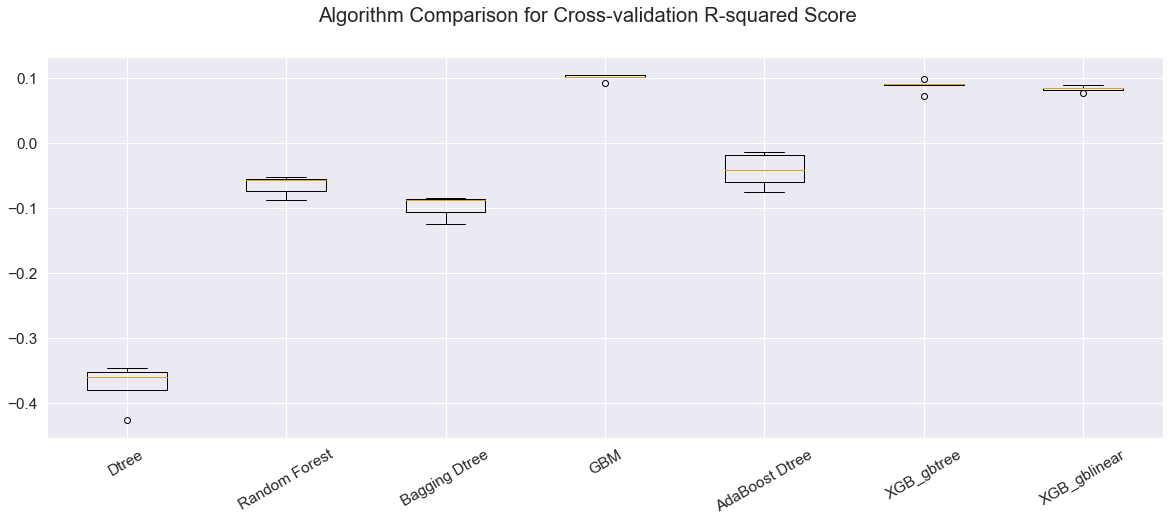

<IPython.core.display.Javascript object>

In [11]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(20, 7))

fig.suptitle("Algorithm Comparison for Cross-validation R-squared Score")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=30)

plt.show()

#### Observations:
- We have negative $R^2$ values for four of the models.  This means they are performing worse than a model that merely equates the predicted values to the constant mean value of the target.
- The remaining three models, *GBM*, *XGB_gbtree*, and *XGB_gblinear* are giving generalized performances on `train` and `validation` sets, with similar, albeit very low, $R^2$ scores as [*olsmodel3*](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_olsmodel_thanak_2022_10_9.ipynb) (0.088).  Before hyperparameter tuning, *GBM* is outperforming the other models, including *olsmodel3*, with both `train` (average of cross-validation folds) and `validation` $R^2$ scores of ~0.10.
- We will perform hyperparameter tuning on the top 3 models.  As an exercise, we will also keep *Random Forest* in the mix.

#### Collecting Models with Best Performance

In [12]:
# List of top models so far
top_models = [models[1]] + [models[3]] + models[-2:]

<IPython.core.display.Javascript object>

#### Creating Dataframes to Compare Training and Validation Performance of Best Models

In [13]:
# Creating empty dictionary to hold the models
models_to_tune = {}

# For loop to add models to dictionary
for model in top_models:
    key = model[0]
    value = model[1]
    models_to_tune[key] = value

# Initializing dataframes to compare performance of all models
models_train_comp_df = pd.DataFrame()
models_val_comp_df = pd.DataFrame()

# For loop to add performance results of each top model
for name, model in models_to_tune.items():
    models_train_comp_df[name] = model_performance_regression(model, X_train, y_train).T
    models_val_comp_df[name] = model_performance_regression(model, X_val, y_val).T

<IPython.core.display.Javascript object>

#### Comparing Top Models Before Hyperparameter Tuning

In [14]:
# Comparing train performance
print(f"Training Performance:")
models_train_comp_df

Training Performance:


,Random Forest,GBM,XGB_gbtree,XGB_gblinear
RMSE,11.686697,14.971421,14.237993,15.179471
MAE,8.736482,11.627512,11.034927,11.784338
R-squared,0.456950,0.108786,0.193965,0.083844
Adj. R-squared,0.456610,0.108228,0.193461,0.083270
MAPE,13.944396,19.221156,18.032207,19.426940


<IPython.core.display.Javascript object>

In [15]:
# Comparing validation performance
print(f"Validation Performance:")
models_val_comp_df

Validation Performance:


,Random Forest,GBM,XGB_gbtree,XGB_gblinear
RMSE,16.271584,14.922006,15.022284,15.059820
MAE,12.558769,11.580272,11.632590,11.696073
R-squared,-0.065931,0.103555,0.091466,0.086920
Adj. R-squared,-0.067489,0.102244,0.090137,0.085585
MAPE,20.193462,19.051063,19.008358,19.183393


<IPython.core.display.Javascript object>

#### Observations:
- Here, we compare the performance on the full `train` set (versus the cross-validation fold average $R^2$) to the `validation` set.
- Only *GBM* and *XGB_gblinear* are giving generalized performances on the two sets.
- These two are performing on par or slightly better than [*olsmodel3*](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_olsmodel_thanak_2022_10_9.ipynb), our linear regression model, for all metrics.
- We will see if hyperparameter tuning improves their performance, again keeping *Random Forest* and *XGB_gbtree* in the mix for demonstration and comparison.

## Hyperparameter Tuning

### *Random Forest Tuned*

In [16]:
# Confirming the model
models_to_tune["Random Forest"]

RandomForestRegressor(random_state=42)

<IPython.core.display.Javascript object>

In [17]:
%%time

# Defining model
Model = RandomForestRegressor(random_state=42)

# Parameter grid to pass in RandomizedSearchCV
param_grid = { 
    "n_estimators": np.arange(100, 500), 
    "min_samples_leaf": [None] + np.arange(1, 10).tolist(),
    "max_features": ['sqrt'], 
    "max_samples": uniform(loc=0.3, scale=0.5),
    'criterion': ['squared_error'],
    "max_depth": [None]
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

Best parameters are {'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.3909124836035503, 'min_samples_leaf': 4, 'n_estimators': 260} with CV score=0.09967033141183923:
CPU times: total: 3.41 s
Wall time: 1min 3s


<IPython.core.display.Javascript object>

In [18]:
# Building model with best parameters
Random_Forest_tuned = RandomForestRegressor(
    criterion="squared_error",
    max_depth=None,
    max_features="sqrt",
    max_samples=0.3909124836035503,
    min_samples_leaf=4,
    n_estimators=260,
)

# Fit the model on training data
Random_Forest_tuned.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', max_samples=0.3909124836035503,
                      min_samples_leaf=4, n_estimators=260)

<IPython.core.display.Javascript object>

In [19]:
# Calculating different metrics
Random_Forest_tuned_train_perf = model_performance_regression(
    Random_Forest_tuned, X_train, y_train
)
print("Training performance:\n", Random_Forest_tuned_train_perf)
Random_Forest_tuned_val_perf = model_performance_regression(
    Random_Forest_tuned, X_val, y_val
)
print("\nValidation performance:\n", Random_Forest_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["Random Forest Tuned"] = Random_Forest_tuned_train_perf.T
models_val_comp_df["Random Forest Tuned"] = Random_Forest_tuned_val_perf.T

Training performance:
       RMSE        MAE  R-squared  Adj. R-squared      MAPE
0  14.5631  11.316087   0.156736        0.156208  18.71272

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.956587  11.607733   0.099395        0.098078  19.104353


<IPython.core.display.Javascript object>

#### Observations:
- Hyperparameter tuning improved performance for *Random Forest*.
- The algorithm is still overfitting the `train` set, compared to the `validation` set.
- Note that we had a 10% fit fail during cross-validation ("UserWarning: One or more of the test scores are non-finite..") indicating cross-validation had some folds for which hyperparameter combinations led to Nan values.  We are going to allow it here, and go with the results of the successful iterations.  The warning messages were suppressed for the most recent run of this notebook.

### *GBM Tuned*

In [20]:
# Confirming the model
models_to_tune["GBM"]

GradientBoostingRegressor(random_state=42)

<IPython.core.display.Javascript object>

In [21]:
%%time

# Defining model
Model = GradientBoostingRegressor(random_state=42)

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "n_estimators": np.arange(100, 500),
    "learning_rate": loguniform(0.001, 1),
    "subsample": uniform(loc=0.3, scale=0.5),
    "max_features": uniform(loc=0.3, scale=0.5),
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=100,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

Best parameters are {'learning_rate': 0.08171272700715591, 'max_features': 0.6630456668613307, 'n_estimators': 368, 'subsample': 0.7847684335570795} with CV score=0.1063224214498147:
CPU times: total: 15.4 s
Wall time: 8min 40s


<IPython.core.display.Javascript object>

In [22]:
# Building model with best parameters
GBM_tuned = GradientBoostingRegressor(
    random_state=42,
    learning_rate=0.08171272700715591,
    max_features=0.6630456668613307,
    n_estimators=368,
    subsample=0.7847684335570795,
)

# Fit the model on training data
GBM_tuned.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.08171272700715591,
                          max_features=0.6630456668613307, n_estimators=368,
                          random_state=42, subsample=0.7847684335570795)

<IPython.core.display.Javascript object>

In [23]:
# Calculating different metrics
GBM_tuned_train_perf = model_performance_regression(GBM_tuned, X_train, y_train)
print("Training performance:\n", GBM_tuned_train_perf)
GBM_tuned_val_perf = model_performance_regression(GBM_tuned, X_val, y_val)
print("\nValidation performance:\n", GBM_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["GBM Tuned"] = GBM_tuned_train_perf.T
models_val_comp_df["GBM Tuned"] = GBM_tuned_val_perf.T

Training performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.835035  11.521845   0.124949        0.124401  18.989296

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.877704  11.542386    0.10887        0.107567  18.937928


<IPython.core.display.Javascript object>

#### Observations:
- The performance for *GBM* is improved with hyperparameter tuning.  
- There is a slight increase in overfitting, but the metrics on the `validation` set are better.

### *XGB_gbtree Tuned*

In [24]:
# Confirming the model
models_to_tune["XGB_gbtree"]

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

<IPython.core.display.Javascript object>

In [25]:
%%time

# Defining model
Model = XGBRegressor(random_state=42, booster='gbtree')

# Parameter grid to pass in RandomizedSearchCV
param_grid={
    'n_estimators': np.arange(100, 500),
    "learning_rate": uniform(0.1, 0.3), # aka eta
    'gamma': expon(), # aka min_split_loss
    'subsample': uniform(loc=0.6, scale=0.2), # proportion of train set to randomly sample prior to growing trees
    'max_depth': np.arange(3, 8).tolist(),
    'colsample_bytree': uniform(loc=0.3, scale=0.5)
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=100,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

Best parameters are {'colsample_bytree': 0.42649508399462055, 'gamma': 1.188792356281234, 'learning_rate': 0.12263036412693079, 'max_depth': 3, 'n_estimators': 404, 'subsample': 0.7391497377969234} with CV score=0.10679644601394585:
CPU times: total: 1min 27s
Wall time: 22min 42s


<IPython.core.display.Javascript object>

In [26]:
# Building model with best parameters
XGB_gbtree_tuned = XGBRegressor(
    booster="gbtree",
    random_state=42,
    colsample_bytree=0.42649508399462055,
    gamma=1.188792356281234,
    learning_rate=0.12263036412693079,
    max_depth=3,
    n_estimators=404,
    subsample=0.7391497377969234,
)

# Fit the model on training data
XGB_gbtree_tuned.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.42649508399462055, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=1.188792356281234, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.12263036412693079, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=404, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, ...)

<IPython.core.display.Javascript object>

In [27]:
# Calculating different metrics
XGB_gbtree_tuned_train_perf = model_performance_regression(
    XGB_gbtree_tuned, X_train, y_train
)
print("Training performance:\n", XGB_gbtree_tuned_train_perf)
XGB_gbtree_tuned_val_perf = model_performance_regression(XGB_gbtree_tuned, X_val, y_val)
print("\nValidation performance:\n", XGB_gbtree_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["XGB_gbtree Tuned"] = XGB_gbtree_tuned_train_perf.T
models_val_comp_df["XGB_gbtree Tuned"] = XGB_gbtree_tuned_val_perf.T

Training performance:
         RMSE       MAE  R-squared  Adj. R-squared       MAPE
0  14.813429  11.50438   0.127496         0.12695  18.953973

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.882834  11.546377   0.108255        0.106951  18.931955


<IPython.core.display.Javascript object>

#### Observations:
- The performance for *XGB_gbtree* is improved with hyperparameter tuning.

### *XGB_gblinear Tuned*

In [28]:
# Confirming the model
models_to_tune["XGB_gblinear"]

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=-1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=0, reg_lambda=0, ...)

<IPython.core.display.Javascript object>

In [29]:
%%time

# Defining model
Model = XGBRegressor(random_state=42, booster='gblinear')

# Parameter grid to pass in RandomizedSearchCV
param_grid={
    'n_estimators': np.arange(100, 500),
    'reg_lambda': loguniform(.0001, 1)
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=100,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

Best parameters are {'n_estimators': 439, 'reg_lambda': 0.0009206654892274761} with CV score=0.09196572057161607:
CPU times: total: 54.6 s
Wall time: 7min 36s


<IPython.core.display.Javascript object>

In [30]:
# Building model with best parameters
XGB_gblinear_tuned = XGBRegressor(
    booster="gblinear",
    random_state=42,
    n_estimators=439,
    reg_lambda=0.0009206654892274761,
)

# Fit the model on training data
XGB_gblinear_tuned.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=-1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=439, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=0, reg_lambda=0.0009206654892274761, ...)

<IPython.core.display.Javascript object>

In [31]:
# Calculating different metrics
XGB_gblinear_tuned_train_perf = model_performance_regression(
    XGB_gblinear_tuned, X_train, y_train
)
print("Training performance:\n", XGB_gblinear_tuned_train_perf)
XGB_gblinear_tuned_val_perf = model_performance_regression(
    XGB_gblinear_tuned, X_val, y_val
)
print("\nValidation performance:\n", XGB_gblinear_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["XGB_gblinear Tuned"] = XGB_gblinear_tuned_train_perf.T
models_val_comp_df["XGB_gblinear Tuned"] = XGB_gblinear_tuned_val_perf.T

Training performance:
         RMSE       MAE  R-squared  Adj. R-squared       MAPE
0  15.100623  11.72536   0.093337        0.092769  19.393922

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.993311  11.635919   0.094967        0.093644  19.152083


<IPython.core.display.Javascript object>

#### Observations:
- *XGB_gblinear* also has improved performance with hyperparameter tuning.
- Let us compare the models, before and after hyperparameter tuning.

## Model Performance Comparison

### Performance of Various Models Tuned and Untuned

In [32]:
# Displaying train performance of all models
print("Train Performance Comparison:")
models_train_comp_df.sort_index(axis=1)

Train Performance Comparison:


,GBM,GBM Tuned,Random Forest,Random Forest Tuned,XGB_gblinear,XGB_gblinear Tuned,XGB_gbtree,XGB_gbtree Tuned
RMSE,14.971421,14.835035,11.686697,14.563100,15.179471,15.100623,14.237993,14.813429
MAE,11.627512,11.521845,8.736482,11.316087,11.784338,11.725360,11.034927,11.504380
R-squared,0.108786,0.124949,0.456950,0.156736,0.083844,0.093337,0.193965,0.127496
Adj. R-squared,0.108228,0.124401,0.456610,0.156208,0.083270,0.092769,0.193461,0.126950
MAPE,19.221156,18.989296,13.944396,18.712720,19.426940,19.393922,18.032207,18.953973


<IPython.core.display.Javascript object>

In [33]:
# Displaying validation performance of all models
print("Validation Performance Comparison:")
models_val_comp_df.sort_index(axis=1)

Validation Performance Comparison:


,GBM,GBM Tuned,Random Forest,Random Forest Tuned,XGB_gblinear,XGB_gblinear Tuned,XGB_gbtree,XGB_gbtree Tuned
RMSE,14.922006,14.877704,16.271584,14.956587,15.059820,14.993311,15.022284,14.882834
MAE,11.580272,11.542386,12.558769,11.607733,11.696073,11.635919,11.632590,11.546377
R-squared,0.103555,0.108870,-0.065931,0.099395,0.086920,0.094967,0.091466,0.108255
Adj. R-squared,0.102244,0.107567,-0.067489,0.098078,0.085585,0.093644,0.090137,0.106951
MAPE,19.051063,18.937928,20.193462,19.104353,19.183393,19.152083,19.008358,18.931955


<IPython.core.display.Javascript object>

#### Observations:
- *GBM Tuned* has the highest $R^2$ (0.109) on the `validation` set, followed by *XGB_gbtree Tuned*, then *GBM*.
- As we did not include the Decision Tree here, we can ignore Adjusted $R^2$, and just compare the $R^2$ scores.
- Of the three models with $R^2$ scores over 10, there is some variation in overfitting.

#### Comparison of Percentage of Overfitting for $R^2$

In [34]:
# Subtracting the ratio of validation R-square/train R-square from 1
overfit_perc = (
    1
    - (
        models_val_comp_df.loc["R-squared", :]
        / models_train_comp_df.loc["R-squared", :]
    )
) * 100

print(f"Percentage of R-square overfitting:")
overfit_perc.sort_values()

Percentage of R-square overfitting:


XGB_gblinear            -3.668505
XGB_gblinear Tuned      -1.746167
GBM                      4.808487
GBM Tuned               12.868707
XGB_gbtree Tuned        15.091493
Random Forest Tuned     36.584275
XGB_gbtree              52.844295
Random Forest          114.428464
Name: R-squared, dtype: float64

<IPython.core.display.Javascript object>

#### Observations:
- *XGB_gblinear* and *XGB_gblinear Tuned* both performed better on the `validation` set, than the `train` set, which is interesting.
- Of the top 3 models for $R^2$ score, *GBM* generalized considerably better than *GBM Tuned* and *XGB_gtree Tuned*.  
- That said, *GBM Tuned* has the highest $R^2$ score on the `validation` set.
- Next we will try another modeling iteration, replacing the one hot encoded `known_for` predictor with the original `known for` category columns.  For linear regression, we grouped entries with multiple `known for` categories into classes to reduce dimensionality.  We retained that approach for the above modeling iteration, but for this iteration we will allow entries to have their original multiple categories.  We will also include the `num_categories` feature in this iteration.

## Second Modeling Iteration: Original `known for` Category Columns and `num_categories`

### Defining Independent and Dependent Variables for `train` and `validation` Sets

In [35]:
# Creating list of predictor columns
predictor_cols = [
    "num_references",
    "years",
    "region",
    "prior_region",
    "sciences",
    "social",
    "spiritual",
    "academia_humanities",
    "business_farming",
    "arts",
    "sports",
    "law_enf_military_operator",
    "politics_govt_law",
    "crime",
    "num_categories",
]

# Defining target column
target = "age"

# Defining independent and dependent variables
X = df[predictor_cols]
y = df[target]

# One hot encoding of categorical predictors and typecasting all predictors as float
X = pd.get_dummies(X, drop_first=True).astype("float64")

# Splitting into 70:30 train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Checking shape of train and validation sets
print(
    f"There are {X_train.shape[0]} rows and {X_train.shape[1]} columns in the train set.\n"
)
print(
    f"There are {X_val.shape[0]} rows and {X_val.shape[1]} columns in the validation set.\n"
)

# Checking a sample
X_train.sample()

There are 54336 rows and 34 columns in the train set.

There are 23288 rows and 34 columns in the validation set.



,num_references,years,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,num_categories,region_Asia,region_Central Asia,region_Europe,region_Mid-Cent America/Caribbean,region_Middle East,region_North America,region_Oceania,region_Russian Federation,region_South America,region_South East Asia,prior_region_Asia,prior_region_Central Asia,prior_region_Europe,prior_region_Mid-Cent America/Caribbean,prior_region_Middle East,prior_region_No Prior Region,prior_region_North America,prior_region_Oceania,prior_region_Russian Federation,prior_region_South America,prior_region_South East Asia
50135,9.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

#### Defining Scorer for Cross-validation and Hyperparameter Tuning

In [36]:
# Type of scoring used to compare parameter combinations--maximizing R-squared
scorer = "r2"

<IPython.core.display.Javascript object>

### Building the Models

In [37]:
%%time

# Creating list to store the models
models = []

# Appending models to the list
models.append(('Dtree2', DecisionTreeRegressor(random_state=42)))

models.append(('Random Forest2', RandomForestRegressor(random_state=42)))

models.append(('Bagging Dtree2', BaggingRegressor(random_state=42)))

models.append(('GBM2', GradientBoostingRegressor(random_state=42)))

models.append(('AdaBoost Dtree2', AdaBoostRegressor(random_state=42)))

models.append(('XGB_gbtree2', XGBRegressor(random_state=42)))

models.append(('XGB_gblinear2', XGBRegressor(random_state=42, booster='gblinear')))

# Create empty list to store all model's names and CV scores
names = []
results = []

# Loop through all models to get the mean cross validated score
print("\n" "Cross-Validation:" "\n")

for name, model in models:
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=5
    )
    results.append(cv_result)
    names.append(name)
    print(f"{name}: {cv_result.mean()}")
    
print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = r2_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation:

Dtree2: -0.39988031150791087
Random Forest2: -0.055391943965687626
Bagging Dtree2: -0.09151226074998306
GBM2: 0.10458496917399238
AdaBoost Dtree2: -0.04659101299906472
XGB_gbtree2: 0.09199892946363704
XGB_gblinear2: 0.08857738131917788

Validation Performance:

Dtree2: -0.3874580410488391
Random Forest2: -0.05737130520636269
Bagging Dtree2: -0.09428953449035293
GBM2: 0.10690165941428653
AdaBoost Dtree2: -0.08047644155074885
XGB_gbtree2: 0.09741681484821774
XGB_gblinear2: 0.09117003022550729
CPU times: total: 5min 55s
Wall time: 1min 47s


<IPython.core.display.Javascript object>

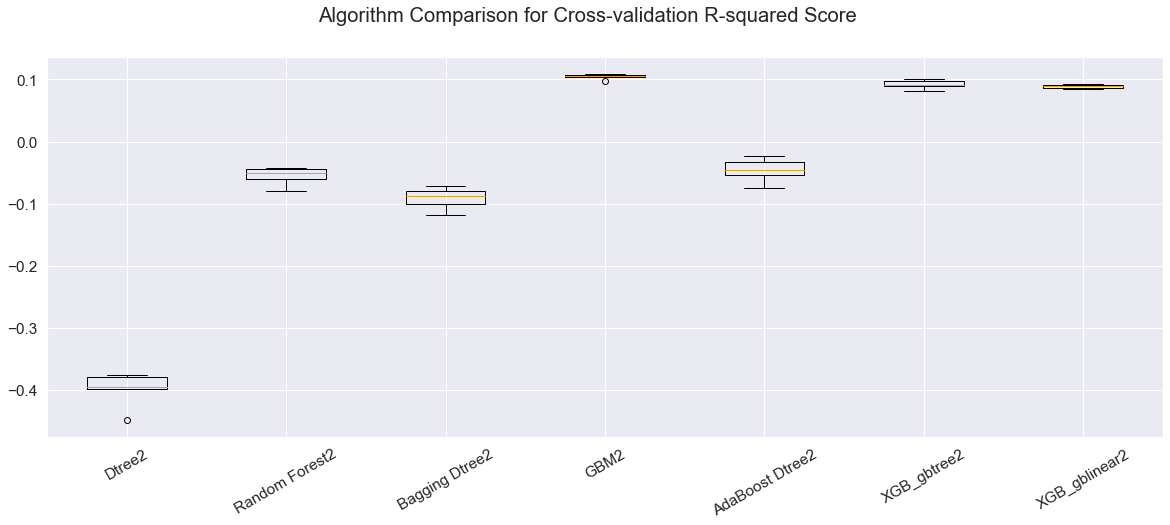

<IPython.core.display.Javascript object>

In [38]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(20, 7))

fig.suptitle("Algorithm Comparison for Cross-validation R-squared Score")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=30)

plt.show()

#### Observations:
- So far, the performances are similar to the first modeling iteration above.
- We will perform hyperparameter tuning on the top 3 models and again keep *Random Forest2* in the mix.

#### Collecting Models with Best Performance

In [39]:
# List of top models so far
top_models = [models[1]] + [models[3]] + models[-2:]

<IPython.core.display.Javascript object>

#### Creating Dataframes to Compare Training and Validation Performance of Best Models

In [40]:
# Creating empty dictionary to hold the models
models_to_tune = {}

# For loop to add models to dictionary
for model in top_models:
    key = model[0]
    value = model[1]
    models_to_tune[key] = value

# For loop to add performance results of each top model
for name, model in models_to_tune.items():
    models_train_comp_df[name] = model_performance_regression(model, X_train, y_train).T
    models_val_comp_df[name] = model_performance_regression(model, X_val, y_val).T

<IPython.core.display.Javascript object>

#### Comparing Top Models Before Hyperparameter Tuning

In [41]:
# Comparing train performance
print(f"Training Performance:")
models_train_comp_df[[key for key in models_to_tune.keys()]]

Training Performance:


,Random Forest2,GBM2,XGB_gbtree2,XGB_gblinear2
RMSE,11.328976,14.937480,14.196740,15.127984
MAE,8.362030,11.599899,10.984573,11.738656
R-squared,0.489686,0.112822,0.198629,0.090049
Adj. R-squared,0.489367,0.112266,0.198128,0.089479
MAPE,13.404005,19.178492,17.982195,19.387390


<IPython.core.display.Javascript object>

In [42]:
# Comparing validation performance
print(f"Validation Performance:")
models_val_comp_df[[key for key in models_to_tune.keys()]]

Validation Performance:


,Random Forest2,GBM2,XGB_gbtree2,XGB_gblinear2
RMSE,16.206121,14.894124,14.973004,15.024728
MAE,12.476262,11.552854,11.582826,11.651800
R-squared,-0.057371,0.106902,0.097417,0.091170
Adj. R-squared,-0.058917,0.105596,0.096097,0.089841
MAPE,20.071146,19.011210,18.941080,19.161592


<IPython.core.display.Javascript object>

#### Observations:
- Here, we compare the performance on the full `train` set (versus the cross-validation fold average $R^2$) to the `validation`set.
- As with the first iteration above, only *GBM2* and *XGB_gblinear2* are giving generalized performances on the two sets.
- We will proceed with hyperparameter tuning.

## Hyperparameter Tuning

### *Random Forest2 Tuned*

In [43]:
# Confirming the model
models_to_tune["Random Forest2"]

RandomForestRegressor(random_state=42)

<IPython.core.display.Javascript object>

In [44]:
%%time

# Defining model
Model = RandomForestRegressor(random_state=42)

# Parameter grid to pass in RandomizedSearchCV
param_grid = { 
    "n_estimators": np.arange(100, 500), 
    "min_samples_leaf": [None] + np.arange(1, 10).tolist(),
    "max_features": ['sqrt'], 
    "max_samples": uniform(loc=0.3, scale=0.5),
    'criterion': ['squared_error'],
    "max_depth": [None]
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

Best parameters are {'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.7162213204002108, 'min_samples_leaf': 5, 'n_estimators': 485} with CV score=0.10627175102316326:
CPU times: total: 12.1 s
Wall time: 1min 25s


<IPython.core.display.Javascript object>

In [45]:
# Building model with best parameters
Random_Forest2_tuned = RandomForestRegressor(
    criterion="squared_error",
    max_depth=None,
    max_features="sqrt",
    max_samples=0.7162213204002108,
    min_samples_leaf=5,
    n_estimators=485,
)

# Fit the model on training data
Random_Forest2_tuned.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', max_samples=0.7162213204002108,
                      min_samples_leaf=5, n_estimators=485)

<IPython.core.display.Javascript object>

In [46]:
# Calculating different metrics
Random_Forest2_tuned_train_perf = model_performance_regression(
    Random_Forest2_tuned, X_train, y_train
)
print("Training performance:\n", Random_Forest2_tuned_train_perf)
Random_Forest2_tuned_val_perf = model_performance_regression(
    Random_Forest2_tuned, X_val, y_val
)
print("\nValidation performance:\n", Random_Forest2_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["Random Forest2 Tuned"] = Random_Forest2_tuned_train_perf.T
models_val_comp_df["Random Forest2 Tuned"] = Random_Forest2_tuned_val_perf.T

Training performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.474581  11.241014   0.166956        0.166434  18.583003

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.906363  11.560092   0.105433        0.104125  19.021093


<IPython.core.display.Javascript object>

#### Observations:
- Hyperparameter tuning improved performance for *Random Forest2*.
- The algorithm is still overfitting the `train` set, compared to the `validation` set.
- Note that we again had a 10% fit fail during cross-validation ("UserWarning: One or more of the test scores are non-finite..") indicating cross-validation had some folds for which hyperparameter combinations led to Nan values.  We are going to allow it here, and go with the results of the successful iterations.  Warning messages were suppressed for the most recent run of this notebook.

### *GBM2 Tuned*

In [47]:
# Confirming the model
models_to_tune["GBM2"]

GradientBoostingRegressor(random_state=42)

<IPython.core.display.Javascript object>

In [48]:
%%time

# Defining model
Model = GradientBoostingRegressor(random_state=42)

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "n_estimators": np.arange(100, 500),
    "learning_rate": loguniform(0.001, 1),
    "subsample": uniform(loc=0.3, scale=0.5),
    "max_features": uniform(loc=0.3, scale=0.5),
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=100,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

Best parameters are {'learning_rate': 0.08171272700715591, 'max_features': 0.6630456668613307, 'n_estimators': 368, 'subsample': 0.7847684335570795} with CV score=0.11041556668246581:
CPU times: total: 14.2 s
Wall time: 7min 34s


<IPython.core.display.Javascript object>

In [49]:
# Building model with best parameters
GBM2_tuned = GradientBoostingRegressor(
    random_state=42,
    learning_rate=0.08171272700715591,
    max_features=0.6630456668613307,
    n_estimators=368,
    subsample=0.7847684335570795,
)

# Fit the model on training data
GBM2_tuned.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.08171272700715591,
                          max_features=0.6630456668613307, n_estimators=368,
                          random_state=42, subsample=0.7847684335570795)

<IPython.core.display.Javascript object>

In [50]:
# Calculating different metrics
GBM2_tuned_train_perf = model_performance_regression(GBM2_tuned, X_train, y_train)
print("Training performance:\n", GBM2_tuned_train_perf)
GBM2_tuned_val_perf = model_performance_regression(GBM2_tuned, X_val, y_val)
print("\nValidation performance:\n", GBM2_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["GBM2 Tuned"] = GBM2_tuned_train_perf.T
models_val_comp_df["GBM2 Tuned"] = GBM2_tuned_val_perf.T

Training performance:
         RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  14.803396  11.49037   0.128678        0.128132  18.95094

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.853802  11.512155   0.111731        0.110432  18.898856


<IPython.core.display.Javascript object>

#### Observations:
- The performance for *GBM2* is improved with hyperparameter tuning.  

### *XGB_gbtree2 Tuned*

In [51]:
# Confirming the model
models_to_tune["XGB_gbtree2"]

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

<IPython.core.display.Javascript object>

In [52]:
%%time

# Defining model
Model = XGBRegressor(random_state=42, booster='gbtree')

# Parameter grid to pass in RandomizedSearchCV
param_grid={
    'n_estimators': np.arange(100, 500),
    "learning_rate": uniform(0.1, 0.3), # aka eta
    'gamma': expon(), # aka min_split_loss
    'subsample': uniform(loc=0.6, scale=0.2), # proportion of train set to randomly sample prior to growing trees
    'max_depth': np.arange(3, 8).tolist(),
    'colsample_bytree': uniform(loc=0.3, scale=0.5)
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=100,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

Best parameters are {'colsample_bytree': 0.6861223846483286, 'gamma': 0.22153944050588595, 'learning_rate': 0.10165663513708073, 'max_depth': 5, 'n_estimators': 180, 'subsample': 0.74226839054973} with CV score=0.11086998659519617:
CPU times: total: 49.1 s
Wall time: 18min 14s


<IPython.core.display.Javascript object>

In [53]:
# Building model with best parameters
XGB_gbtree2_tuned = XGBRegressor(
    booster="gbtree",
    random_state=42,
    colsample_bytree=0.6861223846483286,
    gamma=0.22153944050588595,
    learning_rate=0.10165663513708073,
    max_depth=5,
    n_estimators=180,
    subsample=0.74226839054973,
)

# Fit the model on training data
XGB_gbtree2_tuned.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6861223846483286, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=0.22153944050588595, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.10165663513708073, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=180, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, ...)

<IPython.core.display.Javascript object>

In [54]:
# Calculating different metrics
XGB_gbtree2_tuned_train_perf = model_performance_regression(
    XGB_gbtree2_tuned, X_train, y_train
)
print("Training performance:\n", XGB_gbtree2_tuned_train_perf)
XGB_gbtree2_tuned_val_perf = model_performance_regression(
    XGB_gbtree2_tuned, X_val, y_val
)
print("\nValidation performance:\n", XGB_gbtree2_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["XGB_gbtree2 Tuned"] = XGB_gbtree2_tuned_train_perf.T
models_val_comp_df["XGB_gbtree2 Tuned"] = XGB_gbtree2_tuned_val_perf.T

Training performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.596533  11.326033   0.152859        0.152329  18.630614

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.867475  11.517005   0.110095        0.108794  18.881056


<IPython.core.display.Javascript object>

#### Observations:
- The performance for *XGB_gbtree2* is improved with hyperparameter tuning.  

### *XGB_gblinear2 Tuned*

In [55]:
# Confirming the model
models_to_tune["XGB_gblinear2"]

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=-1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=0, reg_lambda=0, ...)

<IPython.core.display.Javascript object>

In [56]:
%%time

# Defining model
Model = XGBRegressor(random_state=42, booster='gblinear')

# Parameter grid to pass in RandomizedSearchCV
param_grid={
    'n_estimators': np.arange(100, 500),
    'reg_lambda': loguniform(.0001, 1)
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=100,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

Best parameters are {'n_estimators': 439, 'reg_lambda': 0.0009206654892274761} with CV score=0.09239924785728368:
CPU times: total: 1min 24s
Wall time: 7min 25s


<IPython.core.display.Javascript object>

In [57]:
# Building model with best parameters
XGB_gblinear2_tuned = XGBRegressor(
    booster="gblinear",
    random_state=42,
    n_estimators=439,
    reg_lambda=0.0009206654892274761,
)

# Fit the model on training data
XGB_gblinear2_tuned.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=-1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=439, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=0, reg_lambda=0.0009206654892274761, ...)

<IPython.core.display.Javascript object>

In [58]:
# Calculating different metrics
XGB_gblinear2_tuned_train_perf = model_performance_regression(
    XGB_gblinear2_tuned, X_train, y_train
)
print("Training performance:\n", XGB_gblinear2_tuned_train_perf)
XGB_gblinear2_tuned_val_perf = model_performance_regression(
    XGB_gblinear2_tuned, X_val, y_val
)
print("\nValidation performance:\n", XGB_gblinear2_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["XGB_gblinear2 Tuned"] = XGB_gblinear2_tuned_train_perf.T
models_val_comp_df["XGB_gblinear2 Tuned"] = XGB_gblinear2_tuned_val_perf.T

Training performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  15.098923  11.721909   0.093541        0.092974  19.394333

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  15.006837  11.637412   0.093333        0.092008  19.171425


<IPython.core.display.Javascript object>

#### Observations:
- The performance of *XGB_gblinear2* is improved with hyperparameter tuning.
- Let us compare the performance of this iteration's models before and after hyperparameter tuning.

## Model Performance Comparison

### Performance of Various Models Tuned and Untuned

In [59]:
# Displaying train performance of all models
print("Train Performance Comparison:")
cols = [column for column in models_train_comp_df.columns if "2" in column]
models_train_comp_df[cols].sort_index(axis=1)

Train Performance Comparison:


,GBM2,GBM2 Tuned,Random Forest2,Random Forest2 Tuned,XGB_gblinear2,XGB_gblinear2 Tuned,XGB_gbtree2,XGB_gbtree2 Tuned
RMSE,14.937480,14.803396,11.328976,14.474581,15.127984,15.098923,14.196740,14.596533
MAE,11.599899,11.490370,8.362030,11.241014,11.738656,11.721909,10.984573,11.326033
R-squared,0.112822,0.128678,0.489686,0.166956,0.090049,0.093541,0.198629,0.152859
Adj. R-squared,0.112266,0.128132,0.489367,0.166434,0.089479,0.092974,0.198128,0.152329
MAPE,19.178492,18.950940,13.404005,18.583003,19.387390,19.394333,17.982195,18.630614


<IPython.core.display.Javascript object>

In [60]:
# Displaying validation performance of all models
print("Validation Performance Comparison:")
models_val_comp_df[cols].sort_index(axis=1)

Validation Performance Comparison:


,GBM2,GBM2 Tuned,Random Forest2,Random Forest2 Tuned,XGB_gblinear2,XGB_gblinear2 Tuned,XGB_gbtree2,XGB_gbtree2 Tuned
RMSE,14.894124,14.853802,16.206121,14.906363,15.024728,15.006837,14.973004,14.867475
MAE,11.552854,11.512155,12.476262,11.560092,11.651800,11.637412,11.582826,11.517005
R-squared,0.106902,0.111731,-0.057371,0.105433,0.091170,0.093333,0.097417,0.110095
Adj. R-squared,0.105596,0.110432,-0.058917,0.104125,0.089841,0.092008,0.096097,0.108794
MAPE,19.011210,18.898856,20.071146,19.021093,19.161592,19.171425,18.941080,18.881056


<IPython.core.display.Javascript object>

#### Observations:
- We see improvement across the board with hyperparameter tuning.  Even *Random Forest2* improved sufficiently to become a contender.
- Let us thin out the model contenders by considering only those with `validation` $R^2$ scores of at least 0.105, from both modeling iterations.

## Performance Comparison of Contender Models

In [61]:
# Displaying train performance of contender models
print("Train Performance Comparison:")
cols = [
    column
    for column in models_train_comp_df.columns
    if models_val_comp_df.loc["R-squared", column] >= 0.105
]
models_train_comp_df[cols].sort_index(axis=1)

Train Performance Comparison:


,GBM Tuned,GBM2,GBM2 Tuned,Random Forest2 Tuned,XGB_gbtree Tuned,XGB_gbtree2 Tuned
RMSE,14.835035,14.937480,14.803396,14.474581,14.813429,14.596533
MAE,11.521845,11.599899,11.490370,11.241014,11.504380,11.326033
R-squared,0.124949,0.112822,0.128678,0.166956,0.127496,0.152859
Adj. R-squared,0.124401,0.112266,0.128132,0.166434,0.126950,0.152329
MAPE,18.989296,19.178492,18.950940,18.583003,18.953973,18.630614


<IPython.core.display.Javascript object>

In [62]:
# Displaying validation performance of contender models
print("Validation Performance Comparison:")
models_val_comp_df[cols].sort_index(axis=1)

Validation Performance Comparison:


,GBM Tuned,GBM2,GBM2 Tuned,Random Forest2 Tuned,XGB_gbtree Tuned,XGB_gbtree2 Tuned
RMSE,14.877704,14.894124,14.853802,14.906363,14.882834,14.867475
MAE,11.542386,11.552854,11.512155,11.560092,11.546377,11.517005
R-squared,0.108870,0.106902,0.111731,0.105433,0.108255,0.110095
Adj. R-squared,0.107567,0.105596,0.110432,0.104125,0.106951,0.108794
MAPE,18.937928,19.011210,18.898856,19.021093,18.931955,18.881056


<IPython.core.display.Javascript object>

#### Observations:
- *GBM* and *GBM Tuned* have one additional feature than the other models, after one hot encoding.  Therefore Ajusted $R^2$ is more relevant here comparing those two models with the others, than previously.
- Regardless, the top models are the same for $R^2$ and Adjusted $R^2$, *GBM2 Tuned*, followed by *XGB_gtree2 Tuned*, then *GBM Tuned*.
- Using the original `known for` category columns instead of `known_for`, with the inclusion of `num_categories`, brought the `validation` $R^2$ scores over 0.11 for two of the models.
- There is some variation in overfitting between the contender models.

#### Comparison of Percentage of Overfit for All 4 Metrics

In [63]:
# Subtracting the ratio of validation R-square/train R-square from 1
overfit_perc = pd.DataFrame()
overfit_perc["R-squared % overfit"] = np.round(
    (
        1
        - (
            models_val_comp_df[cols].T["R-squared"]
            / models_train_comp_df[cols].T["R-squared"]
        )
    )
    * 100,
    1,
)
for metric in ["RMSE", "MAE", "MAPE"]:
    overfit_perc[f"{metric} % overfit"] = np.round(
        (1 - (models_train_comp_df.T[metric] / models_val_comp_df.T[metric])) * 100, 1
    )

overfit_perc["% Overfit Average of 4 Metrics"] = np.round(
    overfit_perc.sum(axis=1) / 4, 1
)

print(f"Percentage of Overfit:")
overfit_perc.sort_values(by="R-squared % overfit")

Percentage of Overfit:


,R-squared % overfit,RMSE % overfit,MAE % overfit,MAPE % overfit,% Overfit Average of 4 Metrics
GBM2,5.2,-0.3,-0.4,-0.9,0.9
GBM Tuned,12.9,0.3,0.2,-0.3,3.3
GBM2 Tuned,13.2,0.3,0.2,-0.3,3.4
XGB_gbtree Tuned,15.1,0.5,0.4,-0.1,4.0
XGB_gbtree2 Tuned,28.0,1.8,1.7,1.3,8.2
Random Forest2 Tuned,36.8,2.9,2.8,2.3,11.2


<IPython.core.display.Javascript object>

#### Observations:
- Of the candidate models for $R^2$ score, *GBM2* gives the most generalized performance.
- That said, *GBM2 Tuned* has the highest $R^2$ score on the `validation` set, followed by *XGB_gbtree2 Tuned*.  
- With limited performance across the board, we will aim to eke out as much predictive capacity as possible by choosing *GBM2 Tuned* as the champion model and *XGB_gbtree2 Tuned* as the challenger.
- It's time to check our champion model's performance on the `test` set.

## Champion Model *GBM2 Tuned* Performance on `test` Set

#### Reading the [Preprocessed Test Set](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_test_preproc.csv)

In [64]:
# Reading the test set
test_data = pd.read_csv("wp_life_expect_test_preproc.csv")

# Making a working copy
test = test_data.copy()

# Checking shape
print(f"There are {test.shape[0]} rows and {test.shape[1]} columns.")

There are 19420 rows and 20 columns.


<IPython.core.display.Javascript object>

In [65]:
# Checking a sample of rows
test.sample(2)

,num_references,age,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,num_categories,age_sqrd,recip_num_references,years,years_sqrd,region,prior_region,known_for
11915,17,75.0,0,0,0,0,1,0,0,0,1,0,2,5625.0,0.058824,20,400,Africa,No Prior Region,two
2689,17,73.0,0,0,0,0,0,0,0,0,1,0,1,5329.0,0.058824,26,676,Asia,No Prior Region,politics_govt_law


<IPython.core.display.Javascript object>

#### Checking Data Types and Null Values

In [66]:
# Checking info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19420 entries, 0 to 19419
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_references             19420 non-null  int64  
 1   age                        19420 non-null  float64
 2   sciences                   19420 non-null  int64  
 3   social                     19420 non-null  int64  
 4   spiritual                  19420 non-null  int64  
 5   academia_humanities        19420 non-null  int64  
 6   business_farming           19420 non-null  int64  
 7   arts                       19420 non-null  int64  
 8   sports                     19420 non-null  int64  
 9   law_enf_military_operator  19420 non-null  int64  
 10  politics_govt_law          19420 non-null  int64  
 11  crime                      19420 non-null  int64  
 12  num_categories             19420 non-null  int64  
 13  age_sqrd                   19420 non-null  flo

<IPython.core.display.Javascript object>

#### Observations:
- The `test` set was preprocessed in the [olsmodel notebook](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_olsmodel_thanak_2022_10_9.ipynb) and has no missing values.
- We will typecast object type features as categorical.

#### Typecasting `region`, `prior_region`, and `known_for` as Categorical

In [67]:
# Typecasting object type features as categorical
test[["region", "prior_region", "known_for"]] = test[
    ["region", "prior_region", "known_for"]
].astype("category")

# Recheck info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19420 entries, 0 to 19419
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   num_references             19420 non-null  int64   
 1   age                        19420 non-null  float64 
 2   sciences                   19420 non-null  int64   
 3   social                     19420 non-null  int64   
 4   spiritual                  19420 non-null  int64   
 5   academia_humanities        19420 non-null  int64   
 6   business_farming           19420 non-null  int64   
 7   arts                       19420 non-null  int64   
 8   sports                     19420 non-null  int64   
 9   law_enf_military_operator  19420 non-null  int64   
 10  politics_govt_law          19420 non-null  int64   
 11  crime                      19420 non-null  int64   
 12  num_categories             19420 non-null  int64   
 13  age_sqrd                   1942

<IPython.core.display.Javascript object>

#### Observations:
- We are ready to define independent and dependent variables.

In [68]:
# Creating list of predictor columns
predictor_cols = [
    "num_references",
    "years",
    "region",
    "prior_region",
    "sciences",
    "social",
    "spiritual",
    "academia_humanities",
    "business_farming",
    "arts",
    "sports",
    "law_enf_military_operator",
    "politics_govt_law",
    "crime",
    "num_categories",
]

# Defining target column
target = "age"

# Defining independent and dependent variables
X_test = test[predictor_cols]
y_test = test[target]

# One hot encoding of categorical predictors and typecasting all predictors as float
X_test = pd.get_dummies(X_test, drop_first=True).astype("float64")

# Checking shape of train and validation sets
print(
    f"There are {X_test.shape[0]} rows and {X_test.shape[1]} columns in the train set.\n"
)

# Checking a sample
X_test.sample()

There are 19420 rows and 34 columns in the train set.



,num_references,years,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,num_categories,region_Asia,region_Central Asia,region_Europe,region_Mid-Cent America/Caribbean,region_Middle East,region_North America,region_Oceania,region_Russian Federation,region_South America,region_South East Asia,prior_region_Asia,prior_region_Central Asia,prior_region_Europe,prior_region_Mid-Cent America/Caribbean,prior_region_Middle East,prior_region_No Prior Region,prior_region_North America,prior_region_Oceania,prior_region_Russian Federation,prior_region_South America,prior_region_South East Asia
10564,5.0,27.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

#### Checking *GBM2_Tuned* Performance on `test` Set

In [69]:
# Checking performance of champion model on test set
GBM2_tuned_test_perf = model_performance_regression(GBM2_tuned, X_test, y_test)
print("Test performance:\n", GBM2_tuned_test_perf)

# Creating test and train performance df
champion_df = pd.DataFrame()
champion_df["GBM2 Tuned Train"] = GBM2_tuned_train_perf.T
champion_df["GBM2 Tuned Test"] = GBM2_tuned_test_perf.T
champion_df.drop("Adj. R-squared", inplace=True)

Test performance:
         RMSE      MAE  R-squared  Adj. R-squared      MAPE
0  14.789777  11.4842   0.110602        0.109042  18.72186


<IPython.core.display.Javascript object>

In [70]:
# Performance on train and test sets
champion_df.loc[["RMSE", "MAE", "MAPE"], "% Overfit"] = np.round(
    (1 - (champion_df.iloc[[0, 1, 3], 0] / champion_df.iloc[[0, 1, 3], 1])) * 100, 2
)
champion_df.loc["R-squared", "% Overfit"] = np.round(
    (1 - champion_df.iloc[2, 1] / champion_df.iloc[2, 0]) * 100, 2
)

print(
    f"Average overfit of the 4 metrics is {np.round(champion_df['% Overfit'].sum()/4,1)}%."
)
champion_df

Average overfit of the 4 metrics is 3.2%.


,GBM2 Tuned Train,GBM2 Tuned Test,% Overfit
RMSE,14.803396,14.789777,-0.09
MAE,11.490370,11.484200,-0.05
R-squared,0.128678,0.110602,14.05
MAPE,18.950940,18.721860,-1.22


<IPython.core.display.Javascript object>

#### Observations:
- *GBM2 Tuned*'s performance is holding up on the unseen test data.
- We have a model that explains ~11.1% of the variation in life span of notable Wikipedia individuals, who meet inclusion criteria.
- The model predicts life expectancy within average errors of ~11.5 years and ~18.7%.
- Let us check the most important predictive features of the model.

### Feature Importance of Champion Model *GBM2 Tuned*

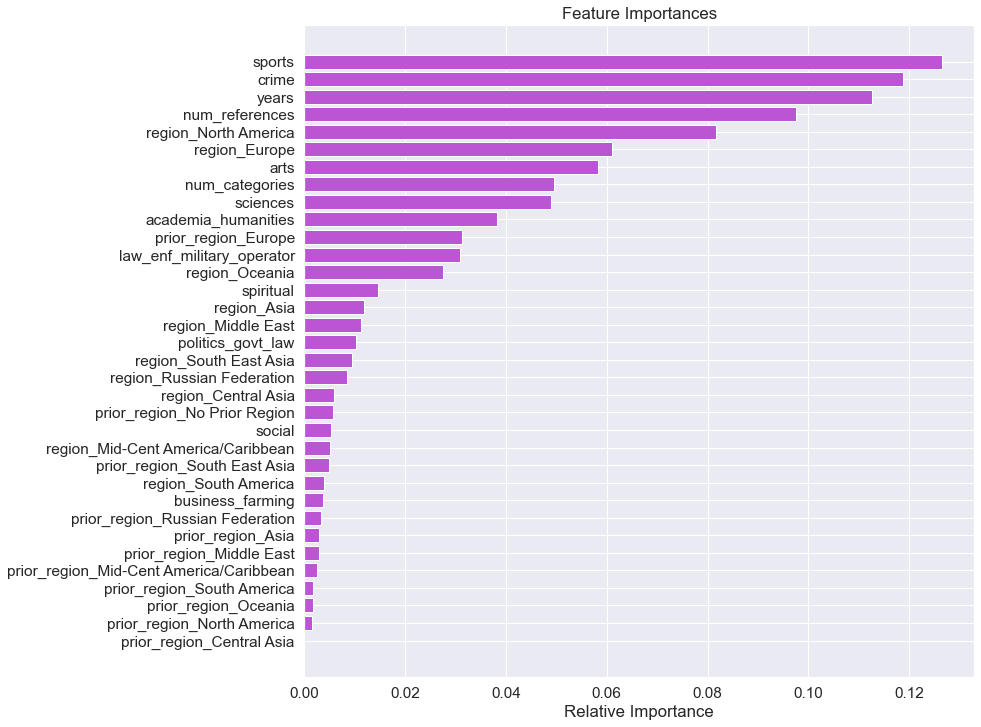

<IPython.core.display.Javascript object>

In [71]:
# Plotting feature importances of final model
feature_names = X_train.columns
importances = GBM2_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(
    range(len(indices)), importances[indices], color="mediumorchid", align="center"
)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

#### Observations:
- The top 10 features of the model for predicting life span of a notable individual are (known for) `sports`, (known for) `crime`, `years`, `num_references`, `region_North America`, `region_Europe`, (known for) `arts`, `num_categories`, (known for) `sciences`, and (known for) `academia_humanities`, in that order.
- Recall from EDA that being known for `crime`, `sports`, or `arts` is associated with shorter life span.  Both in EDA and with our linear regression model, we saw that `age` increases with `years`, yet decreases with `num_references`.  Similarly, in [*olsmodel3*](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_olsmodel_thanak_2022_10_9.ipynb), the combined class of `region_Europe_OR_North_America_OR_Asia` is associated with longer life span (~10 year increase).
- So, the feature importances for our champion model, *GBM2 Tuned* are not surprising.
- Of the 34 predictor variables, 33 have predictive value in the model.  `prior_region_Central_Asia` is the exception.
- The next step in the machine learning process is to productionize the model.  For this study, there is not a practical application for putting the model into production, but we will illustrate the steps as an exercise.

## Pipelines to Productionize the Final Model
Let us assume that new data would be scraped on a monthly basis and treated, as before. up to the following 14-feature stage:
- `num_references` (int64)
- `years` (int64)
- known for category features (int64 of 0 or 1):
    - `sciences` 
    - `social`
    - `spiritual`
    - `academia_humanities`
    - `business_farming`, 
    - `arts`
    - `sports`
    - `law_enf_military_operator`
    - `politics_govt_law`
    - `crime`
- `num_categories` (int64)
- `region` (object)
- `prior_region` (object)

New data should not have missing values for the `known for` category columns since their default value is 0.  Therefore, `num_categories` should not have missing values, either.  `prior_region` will have a default of `No Prior Region`, so should also not have missing values.

Missing values for `region` will need to be treated prior to one hot encoding of both the `Train` set (for fitting the imputer) and the new data.  A step for one hot encoding will follow.  The final step will be the model pipeline.

We have not had to treat any missing values for `num_references` and `years` columns previously, and the procedure for collecting data plus the inclusion criteria (minimum of 3 references) should prevent the need for it.  The only transformation in the model is the translation from `year` to `years` in which we subtracted 1994.  As such, our model pipeline does not contain additional estimators for imputation or scaling that are often included in production pipelines.

Since we already know the best model, we no longer need to have the `Train` set divided into 2 parts (`train` and `validation`), so we can use the whole `Train` set to fit the production pipeline.  To test code and illustrate the process, we will create a dummy new data set, `new`, from the preprocessed `test` set and introduce some missing values in the `region` column.

Once we have the production model fit on the Train set, we will again check its performance on the `test` set.

#### Defining Independent and Dependent Variables for `Train` Set (prior to one hot encoding)

In [72]:
# Defining predictor columns
predictor_cols = [
    "num_references",
    "sciences",
    "social",
    "spiritual",
    "academia_humanities",
    "business_farming",
    "arts",
    "sports",
    "law_enf_military_operator",
    "politics_govt_law",
    "crime",
    "num_categories",
    "years",
    "region",
    "prior_region",
]

# Defining target column
target = "age"

# Defining train dependent and independent variables (not yet one hot encoded)
X_train = df[predictor_cols]
y_train = df[target]

# Checking shape of X_train
X_train.shape

(77624, 15)

<IPython.core.display.Javascript object>

#### Creating a Dummy New Data Set to Test Production Code with Some Missing Values

In [73]:
# Creating a practice new data set
new = pd.read_csv("wp_life_expect_test_preproc.csv")
new = new.sample(100, random_state=42).reset_index(drop=True)

# Creating some missing values for region
new.loc[45:55, "region"] = np.nan

# Defining predictor columns
X_new = new[predictor_cols]

# Defining target
y_new = new[target]

# Checking shape of X_new
X_new.shape

(100, 15)

<IPython.core.display.Javascript object>

### Step 1:  Imputation for Missing Values in New Data for `region` 

#### Building a Custom Imputer to Group on Other Feature(s)<sup>4</sup>

In [74]:
# Creating class GroupImputer
class GroupImputer(
    BaseEstimator, TransformerMixin
):  # Define class with inheritance from sklearn.base classes
    """
    Class used for imputing missing values in a pd.DataFrame using mean, median, or mode of a group
    
    Parameters
    ----------
    group_cols: (list of strings) list of columns on which to group to calculate aggregated value
    target: (str) the name of the column with missing values to be treated
    strategy: (str) "mean", "median", or "mode" (default is "mean")
    
    Returns
    -------
    X: (array-like)
        The array with imputed values in the treated column
    """

    def __init__(self, group_cols, target, strategy="mean"):  # Initialize

        assert strategy in [
            "mean",
            "median",
            "mode",
        ], "Unrecognized value for strategy, should be mean/median/mode"  # Message if strategy not in list
        assert (
            type(group_cols) == list
        ), "group_cols should be a list of columns"  # Message if not a list
        assert (
            type(target) == str
        ), "target should be a string"  # Message if not a string

        self.group_cols = group_cols  # Assign class attribute
        self.target = target  # Assign class attribute
        if strategy in ["mean", "median"]:  # For mean and median
            self.strategy = strategy
        else:
            self.strategy = lambda x: pd.Series.mode(x)[0]  # For mode

    def fit(
        self, X, y=None
    ):  # Class method to fit on array-like X (y (target feature) included here
        # for sklearn class commpatibility only)
        assert (
            pd.isnull(X[self.group_cols]).any(axis=None) == False
        ), "There are missing values in group_cols"  # Message if there are missing values in group_cols

        impute_map = (
            X.groupby(self.group_cols)[
                self.target
            ]  # New dataframe of aggregate value for target column for group
            .agg(self.strategy)
            .reset_index(drop=False)
        )

        self.impute_map_ = impute_map  # Assigning class attribute for impute_map

        return self  # fit method must always return self!

    def transform(
        self, X, y=None
    ):  # Class method to transform array-like X (y (target feature) included here
        # for sklearn class commpatibility only)
        # Make sure that the imputer was fitted
        check_is_fitted(self, "impute_map_")

        X = X.copy()  # Avoiding transformation of original data

        for (
            index,
            row,
        ) in (
            self.impute_map_.iterrows()
        ):  # Iterating through impute_map_ rows (returns index and row data)
            ind = (X[self.group_cols] == row[self.group_cols]).all(
                axis=1
            )  # Creating Boolean Series for matching indices
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(
                row[self.target]
            )  # Fill target Nans w/ group agg value

        return X.values  # Returns numpy array of original X with missing values treated

<IPython.core.display.Javascript object>

In [75]:
# Checking for missing values in new
X_new.isna().sum()

num_references                0
sciences                      0
social                        0
spiritual                     0
academia_humanities           0
business_farming              0
arts                          0
sports                        0
law_enf_military_operator     0
politics_govt_law             0
crime                         0
num_categories                0
years                         0
region                       11
prior_region                  0
dtype: int64

<IPython.core.display.Javascript object>

In [76]:
# Creating list of columns on which to group
group_cols = [
    "sciences",
    "social",
    "spiritual",
    "academia_humanities",
    "business_farming",
    "arts",
    "sports",
    "law_enf_military_operator",
    "politics_govt_law",
    "crime",
]

# Defining imputer for region missing values
region_imp = GroupImputer(group_cols=group_cols, target="region", strategy="mode")

# Fitting region_imp on train set
region_imp.fit(X_train)

# Transforming new data
imp_X_new = pd.DataFrame(region_imp.transform(X_new), columns=X_train.columns)

print(f"There are {X_new.isna().sum().sum()} missing values in X_new.")
print(f"There are {imp_X_new.isna().sum().sum()} missing values in imp_X_new.")

# Visualizing treated missing values
print(f"\nThe imputed values for region now in new data:")
imp_X_new.loc[45:55, "region"]

There are 11 missing values in X_new.
There are 0 missing values in imp_X_new.

The imputed values for region now in new data:


45    North America
46    North America
47    North America
48           Europe
49    North America
50           Europe
51    North America
52           Europe
53    North America
54    North America
55    North America
Name: region, dtype: object

<IPython.core.display.Javascript object>

#### Observations:
- Best practice is to leave the original dataframe untreated in the transformation and create a new transformed dataframe.<sup>5</sup>
- Here, we see that the original `X_new` still has its missing values, while the transformed `imp_X_new` does not.
- `imp_X_new` is the set to carry forward.
- Transformers convert everything to a numpy array, so we converted back to a pandas dataframe at the transform step.  However, numpy arrays allow for only one data type, defaulting to the lowest type on the hierarchy present.  So, we have all object types in `imp_X_new` and need to do some typecasting.
- In this step, we will impose the category classes in the `Train` set onto the `imp_X_new` set, in order to avoid a mismatch of columns between the sets once one hot encoded.  Otherwise, if the new data did not contain a class, it would not have a one hot encoded column corresponding to that class.

#### Checking Data Types of `imp_X_new`

In [77]:
# Checking info
imp_X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   num_references             100 non-null    object
 1   sciences                   100 non-null    object
 2   social                     100 non-null    object
 3   spiritual                  100 non-null    object
 4   academia_humanities        100 non-null    object
 5   business_farming           100 non-null    object
 6   arts                       100 non-null    object
 7   sports                     100 non-null    object
 8   law_enf_military_operator  100 non-null    object
 9   politics_govt_law          100 non-null    object
 10  crime                      100 non-null    object
 11  num_categories             100 non-null    object
 12  years                      100 non-null    object
 13  region                     100 non-null    object
 14  prior_regio

<IPython.core.display.Javascript object>

#### Typecasting `imp_X_new` Columns

In [78]:
# Creating list of numerica columns
numeric_cols = [
    "num_references",
    "sciences",
    "social",
    "spiritual",
    "academia_humanities",
    "business_farming",
    "arts",
    "sports",
    "law_enf_military_operator",
    "politics_govt_law",
    "crime",
    "num_categories",
    "years",
]

# Typecasting numeric columns as float64
imp_X_new[numeric_cols] = imp_X_new[numeric_cols].astype("float64")

# Typecasting categorical columns as category with custom category type including all X_train categories
# in case any classes missing in new data
# For region
categories = X_train["region"].value_counts().index.sort_values().tolist()
cat_dtype = CategoricalDtype(categories=categories, ordered=False)
imp_X_new["region"] = imp_X_new["region"].astype(cat_dtype)

# For prior_region
categories = X_train["prior_region"].value_counts().index.sort_values().tolist()
cat_dtype = CategoricalDtype(categories=categories, ordered=False)
imp_X_new["prior_region"] = imp_X_new["prior_region"].astype(cat_dtype)

<IPython.core.display.Javascript object>

In [79]:
# Re-checking info
imp_X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   num_references             100 non-null    float64 
 1   sciences                   100 non-null    float64 
 2   social                     100 non-null    float64 
 3   spiritual                  100 non-null    float64 
 4   academia_humanities        100 non-null    float64 
 5   business_farming           100 non-null    float64 
 6   arts                       100 non-null    float64 
 7   sports                     100 non-null    float64 
 8   law_enf_military_operator  100 non-null    float64 
 9   politics_govt_law          100 non-null    float64 
 10  crime                      100 non-null    float64 
 11  num_categories             100 non-null    float64 
 12  years                      100 non-null    float64 
 13  region                     100 non-n

<IPython.core.display.Javascript object>

### Step 2: One Hot Encoding of `Train` and `new` Data Predictors

In [80]:
# One hot encoding of train set
X_train = pd.get_dummies(X_train, drop_first=True)

# One hot encoding of new data
imp_X_new = pd.get_dummies(imp_X_new, drop_first=True)

print(X_train.shape, imp_X_new.shape)

(77624, 34) (100, 34)


<IPython.core.display.Javascript object>

In [81]:
# Confirming that columns match in train and new sets
if X_train.columns.tolist() == imp_X_new.columns.tolist():
    print(f"Columns of new data match training set columns.")
else:
    print(f"New data columns do not match training set columns.")

Columns of new data match training set columns.


<IPython.core.display.Javascript object>

### Step 3: Creating Pipeline with Best Parameters

#### Preprocessor for Pipeline
Note that we do not have any transformers in the preprocessor, as we needed to complete that step while the `Train` and `new` sets `region` columns were still of category types.  But, we are including the preprocessor here for illustration, and the ColumnTransformer to pass through any hypothetical new features that are not in the model (e.g., `cause_of_death`).

In [82]:
# Using column transformer to address any new columns not present in numerical_features
# to pass through without any changes; transformers included for illustration only as we are not using any
preprocessor = ColumnTransformer(transformers=[], remainder="passthrough",)

<IPython.core.display.Javascript object>

#### Creating Production Model Pipeline with Best Parameters

In [83]:
# Creating pipeline with best parameters
production_model = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "GBM2 Tuned",
            GradientBoostingRegressor(
                random_state=42,
                learning_rate=0.08171272700715591,
                max_features=0.6630456668613307,
                n_estimators=368,
                subsample=0.7847684335570795,
            ),
        ),
    ]
)

# Fit the model on Train data
production_model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough', transformers=[])),
                ('GBM2 Tuned',
                 GradientBoostingRegressor(learning_rate=0.08171272700715591,
                                           max_features=0.6630456668613307,
                                           n_estimators=368, random_state=42,
                                           subsample=0.7847684335570795))])

<IPython.core.display.Javascript object>

#### Observations:
- We have the steps in place for new data and the production model is ready.
- Let us see how it performs on the `test` set.

### Checking the Production Model on the `test` Set

In [84]:
# Checking model performance on Test set
production_model_test = model_performance_regression(production_model, X_test, y_test)

print("Performance in Production:")
production_model_test.drop("Adj. R-squared", axis=1)

Performance in Production:


,RMSE,MAE,R-squared,MAPE
0,14.774222,11.475362,0.112471,18.711866


<IPython.core.display.Javascript object>

#### Observations:
- Training the champion model on the full `Train` set gave a slight bump up in performance.  $R^2$ increased from 0.111 to 0.112, so the model's performance is holding up in production.  The predictors in the model account for ~11.2% of the variation in life span.
- In production, the champion model is able to predict life span of notable individuals on Wikipedia, who meet inclusion criteria, within an average error of ~11.5 years or ~18.7%.
- Compared to the suggested benchmark of $R^2$ > 0.35 for machine learning models in the social sciences,<sup>6</sup> the model is not a very good predictor.  However, given the very narrow breadth of included predictors (region, prior region (if any), number of references (a proxy for notability), year of death, and the domain(s) for which the individual was known), explaining 11.2% of the variation in life span is reasonable.  For example, other potentially predictive features such as gender, marital status, income, education level, ethnicity, etc., are not overtly present in the model.  It is feasible that the addition of some other key predictors to the current model's predictors (i.e., not in lieu of them) could close the gap between the model's performance and the domain's benchmark minimum $R^2$ for performance.
- By applying more robust machine learning algorithms with hyperparameter tuning and utilizing the original `known for` category columns and `num_cateogories`, we were able to increase the amount of variation in life span explained by the predictors from ~8.8% ([*olsmodel3*](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_olsmodel_thanak_2022_10_9.ipynb)) to ~11.2% (*GBM2_tuned*).
- For the final steps, we will make age predictions on our dummy `new` data, then save it as a pickle file.  We will also save `X_test` as a csv file for potential re-testing of shared model.

#### Predicting Age with Productionized Model

In [85]:
# Predicting age
print(f"Predicted age values on new data:")
production_model.predict(imp_X_new)

Predicted age values on new data:


array([78.43757534, 85.94418736, 78.90627027, 65.92306242, 74.07049642,
       75.28819662, 75.66740056, 73.87320603, 74.2424208 , 83.25488403,
       79.64014232, 79.46225187, 71.42282326, 77.38828781, 78.19017684,
       80.5081493 , 79.33153065, 75.88270439, 82.14288316, 76.33523208,
       79.69487408, 77.03457097, 83.76653577, 81.04773258, 66.56528304,
       75.93985247, 79.42572086, 77.38347886, 74.95825171, 82.1222527 ,
       79.62678031, 80.47238947, 77.19386418, 74.81882556, 78.04700861,
       78.09333454, 83.84287815, 77.68602107, 72.3648586 , 80.87139198,
       74.59543342, 72.09744963, 78.85706564, 77.05209047, 81.11761284,
       74.81882556, 74.93919414, 74.59227409, 71.30475529, 77.0416801 ,
       76.2856974 , 80.28862405, 85.13683126, 78.85075521, 82.14288316,
       77.03685469, 87.10523989, 69.04681621, 84.54949622, 81.11666899,
       78.50818905, 82.70085956, 83.68567616, 74.9887011 , 79.55590074,
       77.50461567, 75.36390586, 75.49077136, 77.90099723, 76.97

<IPython.core.display.Javascript object>

## Saving Productionized Model in a Pickle File and `X_test` as csv

In [86]:
# Saving productionized model in a pickle file
with open("production_model.pkl", "wb") as f:
    pickle.dump(production_model, f)

# Saving X_test as csv
X_test.to_csv("X_test.csv", index=False)

<IPython.core.display.Javascript object>

In [87]:
print("Complete")

# Chime notification when cell executes
chime.success()

Complete


<IPython.core.display.Javascript object>

# Project Recap
### We set out to answer the question:
>*If a person makes the [Wikipedia Notable Deaths](https://en.wikipedia.org/wiki/Deaths_in_2022) list,<sup>7</sup> is there information there that can be used to model and predict that person's life span?*
>
As intended, the journey took us through the processes of Web scraping, cleaning (*very*) messy data, and solving a regression problem.

### Along the way, we made key decisions as to which path to take:

- During **data collection**, the number of references for each individual's Wikipedia page was collected as a proxy for notability.  This feature, `num_references`, has the 4th highest importance of predictors in the champion model. 
- Nearing completion of the first attempt, extracting `known for` information (the most challenging and lengthy phase of both **data cleaning** and the project overall) was completely rebooted.  It was at that point that the current standardized version of its code was realized.  The difficult but worthwhile decision was made to redo that step with the better code.  
- The inclusion criterion of having at least 3 references was also decided during **data cleaning**, at the cost of reducing the size of the dataset, but with the benefit of increased focus on more notable individuals.  The decision came with the secondary benefit of reducing the extraction time for the `known for` categories.
- Delineating the `known for` categories, also part of **data cleaning**, was its own challenge and potential source of bias and noise.  The programatically-driven manual approach to extracting this information was beneficial over a purely manual approach, in that prior iterations on earlier searched columns could be easily referenced or updated for consistency and accuracy.
- Additional inclusion criteria were added at the start of **EDA**, to focus the study on notability for proactive living, rather than for passive association with events or characteristics.  They included minimum attained age of 18 and being `known for` at least one category other than `event_record_other`--an inherently noisy class that accounts for individuals known for extreme age, physical characteristics, association with or being the victim of an event, etc.  To follow suit for the remaining entries, the `event_record_other` category was then dropped, altogether.
- Also during **EDA**, a new `known_for` feature was engineered by combining `known for` categories into a single column, with 2 new classes for entries with multiple categories ("two" and "three_to_five").  The original columns would have been problematic for linear regression interpretation, due to some individuals having multiple categories.
- For emphasis on **interpretability**, a **linear regression model** was built, though the assumption of normally distributed residuals was sacrificed for ease of coefficient interpretation.  
- For better **prediction**, **model building with various ensemble regressors with hyperparameter tuning** was performed.  Before choosing the champion model, separate iterations of model building were conducted: (1) with the engineered combined `known_for` feature, and (2) with the original `known for` categories plus `num_categories` (number of `known for` categories for and individual).

### What did we find?
We analyzed a dataset of over 78,000 (in-sample) entries of notable indviduals scraped from [Wikipedia Notable Deaths](https://en.wikipedia.org/wiki/Deaths_in_January_1994) for January, 1, 1994, through June 9, 2022,<sup>8</sup> with the goal of ascertaining if the information there was sufficient to model a notable individual's life span.  An additional ~19,400 entries were maintained separately for testing.  Highlights include observed characteristics of the dataset, interpretation of key predictive features, and model performance.
#### Observed Characteristics of the Dataset
- Life span ranges from 18 to 122, averaging ~77 years.  
- The  number of references ranges from 3 to 660, with at least 75% of entries having or fewer references. 
- Of the 11 residency regions, North America is the top value, followed by Europe, accounting for \~73% of entries combined.
- Over 94% of entries have a single region of residency.  The most relocations came from European countries (\~3% of entries).
- The vast majority (\~86%) of entries have a single known for category, but there are entries with as many as 5 categories.
- Just over 1/3 of entries are known for arts, followed by sports, then politics_govt_law, which combined also make up just over 1/3 of entries. 

#### Interpretation of Key Predictors from EDA, Linear Regression *olsmodel3*, and Champion Model *GBM2_tuned*
- *Notoriety does not beget longevity.*
    - Notables in the crime category have the shortest average life span, of ~55 years.
    - In *olsmodel3*, being known for crime is associated with a 23.5-year decrease in age.* 
    - In the the champion model, *GBM2_tuned*, (known for) crime is the 2nd most important predictive feature.
- *When it comes to life span, more publicity is not better.*
    - In *olsmodel3*, a 10 unit increase in number of references is associated with a 0.4-year decrease in age.*  The finding may reflect well-known convicted criminals (i.e., with shorter life spans) and the unexpected deaths of other famous younger individuals drawing more attention, keeping in mind that association does not imply causation.  In contrast, longer living individuals have more time to make their mark, but  that possibility does not offset the other underlying contributing factors associating decreased life span with increased notability.
    - In the champion model, *GBM2_tuned*, number of references is the 4th most important predictive feature.
- *Mind vs Body Connection?*
    - Notables in the sports category have the second shortest average life span, of ~72 years, while those in spiritual and sciences categories have the highest, of ~82 years.
    - In *olsmodel3*, being known for sports  is associated with a 7-year decrease in age, while being known for spiritual living or sciences is associated with a 3.5-year or 3-year increase in age, respectively.*
    - In the champion model, *GBM2_tuned*, (known for) sports is the most important predictive feature.  Sciences and spiritual known for features are 9th and 14th, respectively.
- *Time will tell.*
    - There is an overall upward trend in mean age with the advancement of year of death.  The net increase in mean life span is ~5 years, from ~74 to ~79 years, from January, 1994, to June, 2022.
    - In *olsmodel3*, a unit increase in years (i.e., year of death) is associated with a 0.2-year increase in age--a finding consistent with the expectation of overall increasing human life expectancy.*
    - In the champion model, *GBM2_tuned*, years (i.e., year of death) the 3rd most important predictive feature.
- *Location, location, location.*
    - Individuals of the Central Asia region have the shortest average life span (\~67 years), followed by Africa (\~69 years), while those of Europe and North America have the longest (\~78 years).
    - In *olsmodel3*, being of region Europe OR North America OR Asia is associated with a nearly 10-year increase in age.*
    - In the champion model, *GBM2_tuned*, regions North America and Europe are the 5th and 6th most important predictive features, respectively.  
    
#### Champion Model and Performance
- The champion model, *GBM2_tuned*, is able to account for ~11.2% of the variation in life span of Wikipedia notables who meet inclusion criteria.  
- The productionized model is able to predict life span of said individuals within an average error of ~11.5 years or ~18.7%.
- Combined, the more robust ensemble algorithm, inclusion of the original `known for` category and `num_categories` predictors, and hyperparameter tuning resulted in an increase of 2.4% in explained variation in life span by the champion model, *GBM2_tuned*, over the linear regression model, *olsmodel3*.  

    ___________________________
    \*All else constant and compared to reference level for categorical features:  
    - region: Africa OR Central Asia  
    - prior_region: Africa, No Prior Region, South America, Central Asia, Mid-Cent America/Caribbean, North America, OR Oceania  
    - known_for: academia_humanities, politics_govt_law, business_farming, OR social  
        

        
## Conclusion
    
#### *Is there information in the [Wikipedia Notable Deaths](https://en.wikipedia.org/wiki/Deaths_in_2022) list with which to model a notable's life span?*<sup>9</sup>
- There is scant predictive information, but not nothing.  

- Compared to the suggested benchmark of $R^2$ > 0.35 for machine learning models in the social sciences,<sup>9</sup> the champion model is not a very good predictor.  However, given the very narrow breadth of included predictors (region, prior region (if any), number of references (a proxy for notability), year of death, and the domain(s) for which the individual was known), explaining 11.2% of the variation in life span is reasonable.

- Other potentially predictive features such as gender, marital status, income, education level, ethnicity, etc., are not overtly present in the model.  It is feasible that the addition of some other key predictors to the current model's predictors (i.e., not in lieu of them) could close the gap between the model's performance and the domain's benchmark minimum $R^2$ for performance.


#### *Follow-up Opportunities:*
- Cause of death was collected but not examined in this project.  COVID-19, suicide, and cancer (many types) stood out anecdotally.  Comparisons of rates, both in-sample (e.g., with regard to `known for` category) and in relation to those of the general population, are potential areas of further study.

- Delineation of `known for` categories is a potential source of bias.  For example, in the current version of the dataset, a person who was known for activism related to an illness, who died at an early age from that illness, is included in either the politics_govt_law or social category (dependent on how their activism manifested).  In many cases, the individual became an activist as a result of the diagnosis.  In a sense, there is a combined passive situation with resultant proactive behavior, for which the person was then known.  The problem for analysis lies in the possibility that the individual is known for activity directly tied to a shortened life span.  Another approach would be to add a `known for` category for such activism.

- A source of noise is whether or not military service is captured by the law_enf_military_operator category.  In particular, males of the World War II generation were very likely to have served.  For those notables who were known specifically for their military service, the category is captured.  For the others, it is hit or miss.  In some instances, the category was captured secondary to a manual check of an individual's page for another reason.  Finding the information within an individual's page is a much more complicated programmatic challenge than scraping the listed information, as we have done here.

___________________
1. Krishna and Ethan, "How to download a Jupyter Notebook from GitHub?" *Stack Exchange, Data Science* (blog), last modified 21 September 2021, https://datascience.stackexchange.com/questions/35555/how-to-download-a-jupyter-notebook-from-GitHub.
2. "Deaths in January 1994" through "Deaths in June 2022" (through June 9, 2022) and each listed individual's page, Wikipedia, accessed (scraped) June 9-10, 2022, https://en.wikipedia.org/wiki/Deaths_in_January_1994; "A List of Nationalities," WorldAtlas, Victor Kiprop, last modified May 14, 2018, https://www.worldatlas.com/articles/what-is-a-demonym-a-list-of-nationalities.html.;  Marijn Huizendveld, *List of nationalities*.  (GitHub, accessed June 17, 2022), https://gist.github.com/marijn/274449#file-nationalities-txt; "Map of the World's Continents and Regions," Nations Online Project, accessed June 29, 2022, https://www.nationsonline.org/oneworld/small_continents_map.htm.
3. See note 2 above.
4. Eryk Lewinson, "Coding a custom imputer in scikit-learn," Towards Data Science, May 21, 2020, https://towardsdatascience.com/coding-a-custom-imputer-in-scikit-learn-31bd68e541de.
5. See note 4 above.
6. "Linear Correlation," DePaul University, accessed November 1, 2022, https://condor.depaul.edu/sjost/it223/documents/correlation.htm.
7. "Deaths in 2022," Wikipedia, last modified October 24, 2022, https://en.wikipedia.org/wiki/Deaths_in_2022.
8. See note 2 above.
9. See note 6 above.

# [Proceed to Model User Interface](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_predict_GUI__thanak_2022_11_06.ipynb)

[Return to README](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/README.md#explore-the-project)